In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.func import vmap, functional_call, grad
from typing import Optional
from dataclasses import dataclass, replace
import numpy as np
import einops
from tqdm.notebook import trange
import time

In [16]:
@dataclass
class Config:
  n_features: int
  n_hidden: int
  n_experts: int # total number of experts
  n_active_experts:int  # no of active experts
  load_balancing_loss: bool

In [ ]:
class MoEModel(nn.Module):
  def __init__(self, 
               config, 
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,               
               device='cuda'):
    super().__init__()
    self.config = config
    self.W_experts = nn.Parameter(torch.empty((config.n_experts, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W_experts)
    self.b_final = nn.Parameter(torch.zeros((config.n_experts, config.n_features), device=device))
    self.gate = nn.Parameter(torch.zeros((config.n_experts, config.n_features), device=device))

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def compute_active_experts(self, features):   
    # features: [..., n_features]
    # gate: [n_experts, n_features]     
    gate_scores = torch.einsum("...f,ef->...e", features, self.gate)
    gate_probs = F.softmax(gate_scores, dim=-1)
    
    top_k_values, top_k_indices = torch.topk(gate_probs, k=self.config.n_active_experts, dim=-1)
    active_mask = torch.zeros_like(gate_probs)
    active_mask = active_mask.scatter(-1, top_k_indices, 1.0)    
    
    load_balance_loss = None
    if self.config.load_balancing_loss:
      # P_i: average router probability for expert i (before top-k selection)
      P_i = torch.mean(gate_probs, dim=tuple(range(gate_probs.dim() - 1)))
      
      # f_i: fraction of tokens actually dispatched to expert i (after top-k selection)
      f_i = torch.mean(active_mask, dim=tuple(range(active_mask.dim() - 1)))
      
      N = self.config.n_experts
      alpha = 0.01
      load_balance_loss = alpha * N * torch.sum(f_i * P_i)
    
    # renormalize gating weights for active experts only
    # sum of probabilities for active experts
    active_sum = torch.sum(gate_probs * active_mask, dim=-1, keepdim=True)
    
    renormalized_weights = torch.where(
        active_mask.bool(),
        gate_probs / active_sum,
        torch.zeros_like(gate_probs)
    )
    return renormalized_weights, top_k_indices, load_balance_loss


  def forward(self, features):
    # features: [..., n_features]    

    expert_weights, top_k_indices, load_balance_loss = self.compute_active_experts(features)
    
    # hidden: [..., n_experts, n_hidden] - compression
    hidden = torch.einsum("...f,efh->...eh", features, self.W_experts)
    
    # expert_outputs: [..., n_experts, n_features]
    expert_outputs = torch.einsum("...eh,efh->...ef", hidden, self.W_experts)
    expert_outputs = expert_outputs + self.b_final
    expert_outputs = F.relu(expert_outputs)
  
    # final_output: [..., n_features] - recons
    final_output = torch.einsum("...e,...ef->...f", expert_weights, expert_outputs)
    return final_output, load_balance_loss

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_features), device=self.W_experts.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_features), device=self.W_experts.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W_experts.device),
    )
    return batch

In [18]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  # Replace trange with regular range
  for step in range(steps):
    step_lr = lr * lr_scale(step, steps)
    for group in opt.param_groups:
      group['lr'] = step_lr
    opt.zero_grad(set_to_none=True)
    batch = model.generate_batch(n_batch)
    out, load_balance_loss = model(batch)
    error = (model.importance*(batch.abs() - out)**2)
    reconstruction_loss = einops.reduce(error, 'b f -> f', 'mean').sum()
    
    loss = reconstruction_loss
    if load_balance_loss is not None:
      loss = loss + load_balance_loss
    
    loss.backward()
    opt.step()
  
    if hooks:
      hook_data = dict(model=model,
                       step=step, 
                       opt=opt,
                       error=error,
                       loss=loss,
                       reconstruction_loss=reconstruction_loss,
                       load_balance_loss=load_balance_loss,
                       lr=step_lr)
      for h in hooks:
        h(hook_data)
    if step % print_freq == 0 or (step + 1 == steps):
      print(f"Step {step}: loss={loss.item():.6f}, lr={step_lr:.6f}")

In [19]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [20]:
config = Config(
    n_features = 5,
    n_hidden = 2,
    n_experts = 10,
    n_active_experts = 3,
    load_balancing_loss = True,
)

model = MoEModel(
    config=config,
    device=DEVICE,
    importance = 0.9**torch.arange(config.n_features),
    feature_probability = torch.tensor(0.1)
)

In [21]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [22]:
optimize(model, n_batch=10, steps=50, print_freq=5)

Step 0: loss=30.146425, lr=0.001000
Step 5: loss=30.218515, lr=0.001000
Step 10: loss=30.116838, lr=0.001000
Step 15: loss=30.115690, lr=0.001000
Step 20: loss=30.036596, lr=0.001000
Step 25: loss=30.015856, lr=0.001000
Step 30: loss=30.022730, lr=0.001000
Step 35: loss=30.022266, lr=0.001000
Step 40: loss=29.982704, lr=0.001000
Step 45: loss=29.984022, lr=0.001000
Step 49: loss=29.936220, lr=0.001000


### `vmap implementation`

In [23]:
def make_functional_model(config, device, importance, feature_probability):
    """separates the model's computation (functions) from its params for vmap"""
    model = MoEModel(config, device=device, importance=importance, feature_probability=feature_probability)
    
    # Extract parameters and buffers as dictionaries
    params = dict(model.named_parameters())
    buffers = dict(model.named_buffers())
    
    def func_model(params_dict, buffers_dict, *inputs):
        state_dict = {**params_dict, **buffers_dict}
        return functional_call(model, state_dict, inputs[0] if len(inputs) == 1 else inputs)
    
    return func_model, params, buffers

def vectorized_forward(params_batch, buffers_batch, features_batch, func_model):
  """in_dims tells vmap that first dim of each input is batch"""
  return vmap(func_model, in_dims=(0, 0, 0))(params_batch, buffers_batch, features_batch)

def generate_vectorized_batch(configs, feature_probs, n_batch, device):
    batches = []
    for config, feat_prob in zip(configs, feature_probs):
        feat = torch.rand((n_batch, config.n_features), device=device)
        batch = torch.where(
            torch.rand((n_batch, config.n_features), device=device) <= feat_prob,
            feat,
            torch.zeros((), device=device)
        )
        batches.append(batch)
    return torch.stack(batches)  # Shape: [n_models, n_batch, n_features]

def stack_state_dicts(state_dicts):
    """stack a list of state dictionaries into a single state dict with batched tensors"""
    if not state_dicts:
        return {}
    
    stacked = {}
    for key in state_dicts[0].keys():
        stacked_tensor = torch.stack([sd[key] for sd in state_dicts])
        stacked[key] = stacked_tensor.detach().requires_grad_(True)
    return stacked

In [24]:
def optimize_vectorized(configs, feature_probs, importances, 
                        device=DEVICE,
                        n_batch=1024, 
                        steps=10_000, 
                        print_freq=100, 
                        lr=1e-3, 
                        lr_scale=constant_lr, 
                        hooks=[]):
    
    func_models = []
    all_params = []
    all_buffers = []

    for config, feat_prob, importance in zip(configs, feature_probs, importances):
        func_model, params, buffers = make_functional_model(config, device, importance, feat_prob)
        func_models.append(func_model)
        all_params.append(params)
        all_buffers.append(buffers)

    stacked_params = stack_state_dicts(all_params)
    stacked_buffers = stack_state_dicts(all_buffers)

    flat_params = list(stacked_params.values())
    
    opt = torch.optim.AdamW(flat_params, lr=lr)

    start = time.time()

    # Replace trange with regular range
    for step in range(steps):
        step_lr = lr * lr_scale(step, steps)
        for group in opt.param_groups:
            group['lr'] = step_lr
        opt.zero_grad(set_to_none=True)

        batch = generate_vectorized_batch(configs, feature_probs, n_batch, device)
        # Use the first func_model since they should all have the same signature
        out, load_balance_loss = vectorized_forward(stacked_params, stacked_buffers, batch, func_models[0])

        stacked_importance = torch.stack(importances)
        error = stacked_importance.unsqueeze(1) * (batch.abs() - out)**2

        reconstruction_losses = einops.reduce(error, 'models b f -> models', 'mean')
        losses = reconstruction_losses
        if load_balance_loss is not None:
            losses = losses + load_balance_loss

        total_loss = losses.sum()

        total_loss.backward()
        opt.step()
        
        if hooks:
            hook_data = dict(models=func_models,
                            step=step, 
                            opt=opt,
                            errors=error,
                            losses=losses,
                            total_loss=total_loss,
                            reconstruction_losses=reconstruction_losses,
                            load_balance_losses=load_balance_loss,
                            lr=step_lr)
            
            for h in hooks:
                h(hook_data)
        if step % print_freq == 0 or (step + 1 == steps):
            print(f"Step {step}: avg_loss={losses.mean().item():.6f}, lr={step_lr:.6f}")

In [25]:
configs = [
    Config(n_features=5, n_hidden=3, n_experts=5, n_active_experts=2, load_balancing_loss=True),
    Config(n_features=5, n_hidden=3, n_experts=5, n_active_experts=2, load_balancing_loss=False),
]

feature_probs = [torch.tensor(0.1), torch.tensor(0.2),]
importances = [0.9**torch.arange(5), 0.8**torch.arange(5),]

optimize_vectorized(configs, feature_probs, importances, n_batch=10, steps=100, device=DEVICE)

Step 0: avg_loss=20.020626, lr=0.001000
Step 99: avg_loss=19.989468, lr=0.001000


In [ ]:
# Tools to classify expert weights into different types (superposition, orthogonal, incomprehensible)

import torch
import numpy as np
from typing import Dict, Any

def classify_expert_weights(expert_weights: torch.Tensor, tolerance: float = 0.1) -> Dict[str, Any]:
    """
    Classify expert weight matrices into different types.
    
    Args:
        expert_weights: Shape [n_experts, n_features, n_hidden]
        tolerance: Tolerance for considering values as 0, 1, or -1
    
    Returns:
        Dictionary with classification results
    """
    n_experts, n_features, n_hidden = expert_weights.shape
    classifications = {}
    
    for expert_id in range(n_experts):
        weights = expert_weights[expert_id].squeeze()  # Shape: [n_features]
        
        # Normalize weights to unit norm for comparison
        weights_norm = weights / torch.norm(weights)
        
        # Check for superposition patterns
        is_superposition = classify_superposition(weights_norm, tolerance)
        
        # Check for orthogonal feature patterns
        is_orthogonal = classify_orthogonal(weights_norm, tolerance)
        
        # Check for incomprehensible patterns
        is_incomprehensible = classify_incomprehensible(weights_norm, tolerance)
        
        # Determine primary classification
        if is_superposition['is_superposition']:
            classification = 'superposition'
            details = is_superposition
        elif is_orthogonal['is_orthogonal']:
            classification = 'orthogonal'
            details = is_orthogonal
        elif is_incomprehensible['is_incomprehensible']:
            classification = 'incomprehensible'
            details = is_incomprehensible
        else:
            classification = 'other'
            details = {'weights': weights_norm.tolist()}
        
        classifications[f'expert_{expert_id}'] = {
            'classification': classification,
            'details': details,
            'raw_weights': weights.tolist()
        }
    
    return classifications

def classify_superposition(weights: torch.Tensor, tolerance: float) -> Dict[str, Any]:
    """Check if weights match superposition patterns like (1, -1) or (-1, 1)."""
    weights_np = weights.cpu().numpy()
    
    # Check for (1, -1) pattern
    pattern1 = np.array([1.0, -1.0])
    pattern1_norm = pattern1 / np.linalg.norm(pattern1)
    
    # Check for (-1, 1) pattern
    pattern2 = np.array([-1.0, 1.0])
    pattern2_norm = pattern2 / np.linalg.norm(pattern2)
    
    # Calculate similarities
    similarity1 = np.abs(np.dot(weights_np, pattern1_norm))
    similarity2 = np.abs(np.dot(weights_np, pattern2_norm))
    
    max_similarity = max(similarity1, similarity2)
    
    if max_similarity > (1.0 - tolerance):
        if similarity1 > similarity2:
            pattern = 'superposition_1_neg1'
            pattern_weights = pattern1_norm
        else:
            pattern = 'superposition_neg1_1'
            pattern_weights = pattern2_norm
        
        return {
            'is_superposition': True,
            'pattern': pattern,
            'similarity': max_similarity,
            'pattern_weights': pattern_weights.tolist()
        }
    
    return {'is_superposition': False}

def classify_orthogonal(weights: torch.Tensor, tolerance: float) -> Dict[str, Any]:
    """Check if weights match orthogonal patterns like (1, 0) or (0, 1)."""
    weights_np = weights.cpu().numpy()
    
    # Check for (1, 0) pattern
    pattern1 = np.array([1.0, 0.0])
    pattern1_norm = pattern1 / np.linalg.norm(pattern1)
    
    # Check for (0, 1) pattern
    pattern2 = np.array([0.0, 1.0])
    pattern2_norm = pattern2 / np.linalg.norm(pattern2)
    
    # Calculate similarities
    similarity1 = np.abs(np.dot(weights_np, pattern1_norm))
    similarity2 = np.abs(np.dot(weights_np, pattern2_norm))
    
    max_similarity = max(similarity1, similarity2)
    
    if max_similarity > (1.0 - tolerance):
        if similarity1 > similarity2:
            pattern = 'orthogonal_feature_0'
            pattern_weights = pattern1_norm
        else:
            pattern = 'orthogonal_feature_1'
            pattern_weights = pattern2_norm
        
        return {
            'is_orthogonal': True,
            'pattern': pattern,
            'similarity': max_similarity,
            'pattern_weights': pattern_weights.tolist()
        }
    
    return {'is_orthogonal': False}

def classify_incomprehensible(weights: torch.Tensor, tolerance: float) -> Dict[str, Any]:
    """Check if weights don't match any clear pattern."""
    weights_np = weights.cpu().numpy()
    
    # Check if weights are roughly equal magnitude but not clear patterns
    weights_abs = np.abs(weights_np)
    mean_magnitude = np.mean(weights_abs)
    std_magnitude = np.std(weights_abs)
    
    # If weights are roughly equal magnitude but not clear patterns
    if std_magnitude < tolerance and mean_magnitude > 0.1:
        return {
            'is_incomprehensible': True,
            'mean_magnitude': mean_magnitude,
            'std_magnitude': std_magnitude,
            'description': 'roughly_equal_magnitude'
        }
    
    # If weights are very small
    if mean_magnitude < tolerance:
        return {
            'is_incomprehensible': True,
            'mean_magnitude': mean_magnitude,
            'description': 'very_small_weights'
        }
    
    return {'is_incomprehensible': False}

def print_classification_summary(classifications: Dict[str, Any]):
    """Print a summary of expert classifications."""
    print("=== Expert Weight Classifications ===")
    
    for expert_id, result in classifications.items():
        classification = result['classification']
        details = result['details']
        
        print(f"\n{expert_id}:")
        print(f"  Classification: {classification}")
        print(f"  Raw weights: {result['raw_weights']}")
        
        if classification == 'superposition':
            print(f"  Pattern: {details['pattern']}")
            print(f"  Similarity: {details['similarity']:.3f}")
        elif classification == 'orthogonal':
            print(f"  Pattern: {details['pattern']}")
            print(f"  Similarity: {details['similarity']:.3f}")
        elif classification == 'incomprehensible':
            print(f"  Description: {details['description']}")
            print(f"  Mean magnitude: {details['mean_magnitude']:.3f}")

# Example usage:
if __name__ == "__main__":
    # Test with your expert weights
    expert_weights = torch.tensor([[[ 0.2857],
                                   [ 0.3748]],
                                  [[-0.9991],
                                   [ 0.4402]]])
    
    classifications = classify_expert_weights(expert_weights, tolerance=0.1)
    print_classification_summary(classifications)

=== Expert Weight Classifications ===

expert_0:
  Classification: incomprehensible
  Raw weights: [0.2856999933719635, 0.3747999966144562]
  Description: roughly_equal_magnitude
  Mean magnitude: 0.701

expert_1:
  Classification: superposition
  Raw weights: [-0.9991000294685364, 0.44020000100135803]
  Pattern: superposition_neg1_1
  Similarity: 0.932


In [ ]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

sys.path.append('.')


# Set device
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

config = Config(
    n_features = 3,
    n_hidden = 2,
    n_experts = 2,
    n_active_experts = 1,
    load_balancing_loss = True,
)

# Configure importance and feature probability (sparsity)
model = MoEModel(
    config=config,
    device=DEVICE,
    importance = torch.tensor([1, 1, 1]),
    feature_probability = torch.tensor(0.01)
)

# Train the model
print("Training model...")
optimize(model, n_batch=512, steps=5000, print_freq=500, lr=1e-3)

print("Gate matrix:")
print(model.gate)
print("Expert weights:")
print(model.W_experts)

# Print final model parameters
print("\nFinal model parameters:")
print(f"Feature probability: {model.feature_probability.item()}")
print(f"Importance weights: {model.importance}")




Training model...
Step 0: loss=10.005443, lr=0.001000
Step 500: loss=9.961046, lr=0.001000
Step 1000: loss=9.930203, lr=0.001000
Step 1500: loss=9.917327, lr=0.001000
Step 2000: loss=9.836444, lr=0.001000
Step 2500: loss=9.851954, lr=0.001000
Step 3000: loss=9.774613, lr=0.001000
Step 3500: loss=9.799587, lr=0.001000
Step 4000: loss=9.797658, lr=0.001000
Step 4500: loss=9.785119, lr=0.001000
Step 4999: loss=9.827586, lr=0.001000
Gate matrix:
Parameter containing:
tensor([[-3.0730, -3.0572, -3.0687],
        [ 3.0730,  3.0572,  3.0687]], requires_grad=True)
Expert weights:
Parameter containing:
tensor([[[-0.0955,  0.4050],
         [ 0.1420, -0.0509],
         [-0.4971, -0.2047]],

        [[-0.7263, -0.6883],
         [ 0.7235, -0.6893],
         [ 0.6434,  0.7625]]], requires_grad=True)

Final model parameters:
Feature probability: 0.009999999776482582
Importance weights: tensor([1, 1, 1])

Expert Weight Classifications:

expert_0:
  Hidden dim 0: orthogonal_feature_2 (similarity: 0.9

In [ ]:
model.compute_active_experts(torch.tensor([1., 0.01])) 

RuntimeError: einsum(): subscript f has size 3 for operand 1 which does not broadcast with previously seen size 2

In [ ]:
def compute_router_probabilities(gate_matrix, feature_probability=None, n_samples=10000):
    """
    Compute probability that router picks first expert.
    
    Args:
        gate_matrix: Shape [n_experts, n_features] - the gate weights
        feature_probability: Probability of feature being active (None for uniform)
        n_samples: Number of samples to estimate probability
    
    Returns:
        prob_with_data: Probability considering data sparsity
        prob_without_data: Probability assuming uniform data
    """
    device = gate_matrix.device
    n_experts, n_features = gate_matrix.shape
    
    # 1. Probability WITHOUT considering data properties (uniform data)
    # Generate uniform random features
    uniform_features = torch.rand(n_samples, n_features, device=device)
    
    # Compute gate scores and probabilities
    gate_scores_uniform = torch.einsum("bf,ef->be", uniform_features, gate_matrix)
    gate_probs_uniform = F.softmax(gate_scores_uniform, dim=-1)
    
    # Probability of selecting first expert
    prob_without_data = gate_probs_uniform[:, 0].mean().item()
    
    # 2. Probability WITH considering data properties (sparse data)
    if feature_probability is not None:
        # Generate sparse data according to feature_probability
        sparse_features = torch.where(
            torch.rand(n_samples, n_features, device=device) <= feature_probability,
            torch.rand(n_samples, n_features, device=device),
            torch.zeros(n_samples, n_features, device=device)
        )
        
        # Compute gate scores and probabilities for sparse data
        gate_scores_sparse = torch.einsum("bf,ef->be", sparse_features, gate_matrix)
        gate_probs_sparse = F.softmax(gate_scores_sparse, dim=-1)
        
        # Probability of selecting first expert
        prob_with_data = gate_probs_sparse[:, 0].mean().item()
    else:
        prob_with_data = prob_without_data
    
    return prob_with_data, prob_without_data

# Example usage:
print("Gate matrix:")
print(model.gate)

print(f"\nFeature probability: {model.feature_probability.item()}")

# Compute probabilities
prob_with_data, prob_without_data = compute_router_probabilities(
    model.gate, 
    feature_probability=model.feature_probability,
    n_samples=10000
)

print(f"\nRouter probabilities for first expert:")
print(f"With data sparsity: {prob_with_data:.3f}")
print(f"Without data sparsity (uniform): {prob_without_data:.3f}")

# For multiple experts, you can also compute for each expert:
def compute_all_expert_probabilities(gate_matrix, feature_probability=None, n_samples=10000):
    """
    Compute probability for each expert being selected.
    """
    device = gate_matrix.device
    n_experts, n_features = gate_matrix.shape
    
    # Uniform data
    uniform_features = torch.rand(n_samples, n_features, device=device)
    gate_scores_uniform = torch.einsum("bf,ef->be", uniform_features, gate_matrix)
    gate_probs_uniform = F.softmax(gate_scores_uniform, dim=-1)
    probs_without_data = gate_probs_uniform.mean(dim=0).cpu().detach().numpy()
    
    # Sparse data
    if feature_probability is not None:
        sparse_features = torch.where(
            torch.rand(n_samples, n_features, device=device) <= feature_probability,
            torch.rand(n_samples, n_features, device=device),
            torch.zeros(n_samples, n_features, device=device)
        )
        gate_scores_sparse = torch.einsum("bf,ef->be", sparse_features, gate_matrix)
        gate_probs_sparse = F.softmax(gate_scores_sparse, dim=-1)
        probs_with_data = gate_probs_sparse.mean(dim=0).cpu().detach().numpy()
    else:
        probs_with_data = probs_without_data
    
    return probs_with_data, probs_without_data

# Compute for all experts
probs_with_data, probs_without_data = compute_all_expert_probabilities(
    model.gate, 
    feature_probability=model.feature_probability
)

print(f"\nRouter probabilities for all experts:")
for i in range(len(probs_with_data)):
    print(f"Expert {i}: with_data={probs_with_data[i]:.3f}, without_data={probs_without_data[i]:.3f}")

Gate matrix:
Parameter containing:
tensor([[-3.2315, -3.2264],
        [ 3.2315,  3.2264]], requires_grad=True)

Feature probability: 0.10000000149011612

Router probabilities for first expert:
With data sparsity: 0.423
Without data sparsity (uniform): 0.020

Router probabilities for all experts:
Expert 0: with_data=0.425, without_data=0.019
Expert 1: with_data=0.575, without_data=0.981


In [ ]:
# Classify expert weights into different types (superposition, orthogonal, incomprehensible)
# This is a simple classification based on the weights of the expert.


# Classify expert weights
def classify_expert_weights(expert_weights: torch.Tensor, tolerance: float = 0.1):
    """Classify expert weight matrices into different types."""
    n_experts, n_features, n_hidden = expert_weights.shape
    classifications = {}
    
    for expert_id in range(n_experts):
        weights = expert_weights[expert_id].squeeze()  # Shape: [n_features, n_hidden]
        
        # For each hidden dimension, classify the feature weights
        hidden_classifications = []
        for hidden_dim in range(n_hidden):
            feature_weights = weights[:, hidden_dim]  # Shape: [n_features]
            weights_norm = feature_weights / torch.norm(feature_weights)
            weights_np = weights_norm.cpu().detach().numpy()
            
            # Check for superposition patterns
            # All three features superimposed
            all_three_patterns = [
                np.array([1.0, 1.0, 1.0]),
                np.array([1.0, 1.0, -1.0]),
                np.array([1.0, -1.0, 1.0]),
                np.array([-1.0, 1.0, 1.0]),
                np.array([1.0, -1.0, -1.0]),
                np.array([-1.0, 1.0, -1.0]),
                np.array([-1.0, -1.0, 1.0]),
                np.array([-1.0, -1.0, -1.0])
            ]
            
            # Pairs of features superimposed
            pair_patterns = [
                np.array([1.0, 1.0, 0.0]),  # Features 0,1 superimposed
                np.array([1.0, 0.0, 1.0]),  # Features 0,2 superimposed
                np.array([0.0, 1.0, 1.0]),  # Features 1,2 superimposed
                np.array([1.0, -1.0, 0.0]), # Features 0,1 superimposed (opposite)
                np.array([1.0, 0.0, -1.0]), # Features 0,2 superimposed (opposite)
                np.array([0.0, 1.0, -1.0]), # Features 1,2 superimposed (opposite)
                np.array([-1.0, 1.0, 0.0]), # Features 0,1 superimposed (opposite)
                np.array([-1.0, 0.0, 1.0]), # Features 0,2 superimposed (opposite)
                np.array([0.0, -1.0, 1.0])  # Features 1,2 superimposed (opposite)
            ]
            
            # Single features (orthogonal)
            single_patterns = [
                np.array([1.0, 0.0, 0.0]),  # Feature 0 only
                np.array([0.0, 1.0, 0.0]),  # Feature 1 only
                np.array([0.0, 0.0, 1.0])   # Feature 2 only
            ]
            
            # Test all patterns
            max_similarity = 0
            best_pattern = None
            best_pattern_type = None
            
            # Test all-three patterns
            for pattern in all_three_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'all_three'
            
            # Test pair patterns
            for pattern in pair_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'pair'
            
            # Test single patterns
            for pattern in single_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'single'
            
            # Determine classification
            if max_similarity > (1.0 - tolerance):
                if best_pattern_type == 'all_three':
                    # Identify which features are superimposed
                    active_features = np.where(np.abs(best_pattern) > 0.1)[0]
                    signs = best_pattern[active_features]
                    if np.all(signs > 0):
                        classification = f'superposition_all_three_positive'
                    elif np.all(signs < 0):
                        classification = f'superposition_all_three_negative'
                    else:
                        classification = f'superposition_all_three_mixed'
                elif best_pattern_type == 'pair':
                    # Identify which pair is superimposed
                    active_features = np.where(np.abs(best_pattern) > 0.1)[0]
                    signs = best_pattern[active_features]
                    feature_names = [f'feature_{i}' for i in active_features]
                    if np.all(signs > 0):
                        classification = f'superposition_pair_{"_".join(feature_names)}_positive'
                    elif np.all(signs < 0):
                        classification = f'superposition_pair_{"_".join(feature_names)}_negative'
                    else:
                        classification = f'superposition_pair_{"_".join(feature_names)}_mixed'
                elif best_pattern_type == 'single':
                    # Identify which single feature
                    active_feature = np.where(np.abs(best_pattern) > 0.1)[0][0]
                    classification = f'orthogonal_feature_{active_feature}'
            else:
                classification = 'incomprehensible'
            
            hidden_classifications.append({
                'classification': classification,
                'similarity': max_similarity,
                'weights': feature_weights.tolist(),
                'pattern': best_pattern.tolist() if best_pattern is not None else None
            })
        
        classifications[f'expert_{expert_id}'] = {
            'hidden_dimensions': hidden_classifications,
            'raw_weights': weights.tolist()
        }
    
    return classifications

# Classify and print results
classifications = classify_expert_weights(model.W_experts)
print("\nExpert Weight Classifications:")
for expert_id, result in classifications.items():
    print(f"\n{expert_id}:")
    for i, hidden_result in enumerate(result['hidden_dimensions']):
        print(f"  Hidden dim {i}: {hidden_result['classification']} (similarity: {hidden_result['similarity']:.3f})")
        print(f"    Weights: {hidden_result['weights']}")
        if hidden_result['pattern']:
            print(f"    Pattern: {hidden_result['pattern']}")

Step 0: loss=10.057854, lr=0.001000
Step 100: loss=9.976372, lr=0.001000
Step 200: loss=9.908997, lr=0.001000
Step 300: loss=9.855118, lr=0.001000
Step 400: loss=9.769238, lr=0.001000
Step 500: loss=9.714314, lr=0.001000
Step 600: loss=9.691904, lr=0.001000
Step 700: loss=9.600872, lr=0.001000
Step 800: loss=9.580305, lr=0.001000
Step 900: loss=9.556435, lr=0.001000
Step 1000: loss=9.534439, lr=0.001000
Step 1100: loss=9.454253, lr=0.001000
Step 1200: loss=9.418459, lr=0.001000
Step 1300: loss=9.411724, lr=0.001000
Step 1400: loss=9.350805, lr=0.001000
Step 1500: loss=9.367863, lr=0.001000
Step 1600: loss=9.343919, lr=0.001000
Step 1700: loss=9.370528, lr=0.001000
Step 1800: loss=9.299060, lr=0.001000
Step 1900: loss=9.267596, lr=0.001000
Step 2000: loss=9.286695, lr=0.001000
Step 2100: loss=9.291334, lr=0.001000
Step 2200: loss=9.250756, lr=0.001000
Step 2300: loss=9.252250, lr=0.001000
Step 2400: loss=9.266186, lr=0.001000
Step 2500: loss=9.234799, lr=0.001000
Step 2600: loss=9.20952

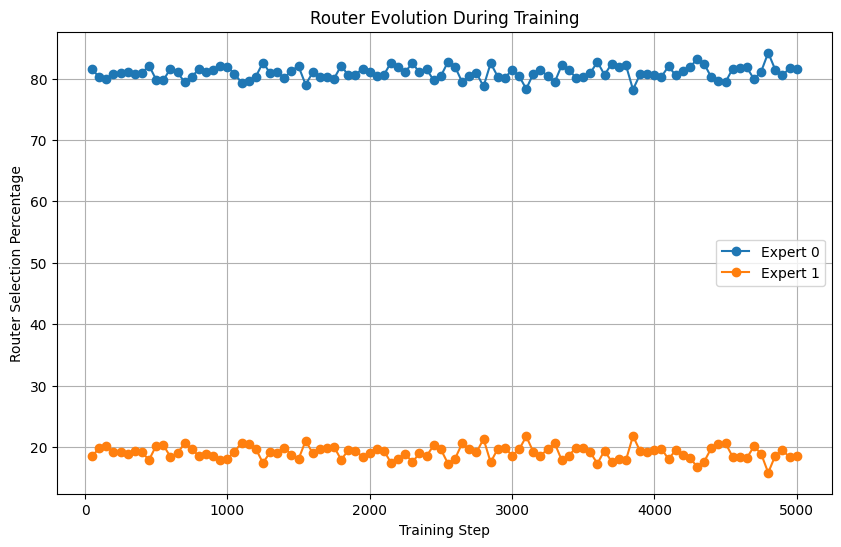

In [ ]:
# Tools to track gate expert selection statistics

import torch
import numpy as np

class RouterSelectionHook:
    def __init__(self):
        self.expert_selections = {}  # {expert_id: count}
        self.total_selections = 0
        self.batch_size = 0
        
    def __call__(self, hook_data):
        """Hook function called during training."""
        model = hook_data['model']
        batch = hook_data.get('batch', None)
        
        if batch is None:
            # Generate a batch to analyze router behavior
            batch = model.generate_batch(1000)  # Use large batch for good statistics
        
        # Get router probabilities for this batch
        with torch.no_grad():
            expert_weights, top_k_indices, _ = model.compute_active_experts(batch)
            
            # For k=1, track which expert was selected for each input
            if model.config.n_active_experts == 1:
                selected_experts = top_k_indices.squeeze(-1)  # [batch_size]
                
                # Count selections for each expert
                for expert_id in selected_experts.cpu().numpy():
                    if expert_id not in self.expert_selections:
                        self.expert_selections[expert_id] = 0
                    self.expert_selections[expert_id] += 1
                
                self.total_selections += len(selected_experts)
                self.batch_size = len(selected_experts)
    
    def get_statistics(self):
        """Get router selection statistics."""
        if self.total_selections == 0:
            return {}
        
        stats = {
            'total_selections': self.total_selections,
            'expert_counts': dict(self.expert_selections),
            'expert_percentages': {}
        }
        
        for expert_id, count in self.expert_selections.items():
            stats['expert_percentages'][expert_id] = (count / self.total_selections) * 100
        
        return stats
    
    def print_statistics(self):
        """Print current router selection statistics."""
        stats = self.get_statistics()
        
        if not stats:
            print("No router selections recorded yet.")
            return
        
        print(f"\n=== Router Selection Statistics ===")
        print(f"Total selections: {stats['total_selections']}")
        print(f"Batch size: {self.batch_size}")
        print(f"Expert counts: {stats['expert_counts']}")
        print(f"Expert percentages:")
        for expert_id, percentage in stats['expert_percentages'].items():
            print(f"  Expert {expert_id}: {percentage:.2f}%")
        
        # Check for load balancing
        n_experts = len(stats['expert_counts'])
        if n_experts > 0:
            expected_percentage = 100.0 / n_experts
            print(f"Expected percentage per expert: {expected_percentage:.2f}%")
            
            # Calculate load balancing metric
            percentages = list(stats['expert_percentages'].values())
            variance = np.var(percentages)
            print(f"Load balancing variance: {variance:.2f}")

# Usage example:
def train_with_router_hook():
    """Train model with router selection tracking."""
    config = Config(
        n_features=2,
        n_hidden=1,
        n_experts=2,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        importance=torch.tensor([1, 1]),
        feature_probability=torch.tensor(0.1)
    )
    
    # Create router hook
    router_hook = RouterSelectionHook()
    
    # Train with hook
    optimize(model, n_batch=512, steps=5000, print_freq=100, lr=1e-3, hooks=[router_hook])
    
    # Print statistics
    router_hook.print_statistics()
    
    return model, router_hook

# Alternative: Hook that tracks router behavior over time
class RouterEvolutionHook:
    def __init__(self, log_interval=100):
        self.log_interval = log_interval
        self.step = 0
        self.router_history = []  # List of (step, expert_percentages) tuples
        
    def __call__(self, hook_data):
        self.step += 1
        
        if self.step % self.log_interval == 0:
            # Create temporary hook to get current statistics
            temp_hook = RouterSelectionHook()
            temp_hook(hook_data)
            
            stats = temp_hook.get_statistics()
            if stats:
                self.router_history.append((self.step, stats['expert_percentages']))
                
                print(f"\nStep {self.step} - Router evolution:")
                for expert_id, percentage in stats['expert_percentages'].items():
                    print(f"  Expert {expert_id}: {percentage:.2f}%")
    
    def plot_evolution(self):
        """Plot router evolution over time."""
        if not self.router_history:
            print("No router history to plot.")
            return
        
        import matplotlib.pyplot as plt
        
        steps = [step for step, _ in self.router_history]
        expert_ids = set()
        for _, percentages in self.router_history:
            expert_ids.update(percentages.keys())
        
        plt.figure(figsize=(10, 6))
        for expert_id in sorted(expert_ids):
            percentages = [data.get(expert_id, 0) for _, data in self.router_history]
            plt.plot(steps, percentages, label=f'Expert {expert_id}', marker='o')
        
        plt.xlabel('Training Step')
        plt.ylabel('Router Selection Percentage')
        plt.title('Router Evolution During Training')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Train with router tracking
    model, router_hook = train_with_router_hook()
    
    # Or train with evolution tracking
    evolution_hook = RouterEvolutionHook(log_interval=50)
    optimize(model, n_batch=512, steps=5000, print_freq=50, lr=1e-3, hooks=[evolution_hook])
    evolution_hook.plot_evolution()